In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import blob_dog, blob_log, blob_doh
import sklearn

C:\Users\Lenovo\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [14]:
class SpotDetection():
    def __init__(self,file,size):
        self.leaf_img = cv2.resize(cv2.imread(file),(size,size))
        self.size = size
        
    def verify_img(self,leaf):
        cv2.imshow('windows1', leaf)
        try:
            cv2.waitKey()
        except KeyboardInterrupt as e:
            print(e)
        cv2.destroyWindow('windows1') 
    
    def create_adaptive_hist(self,img):
        lab_img = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(lab_img)
        clache = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
        lab_planes[0] = clache.apply(lab_planes[0])
        lab_planes = cv2.merge(lab_planes)
        color_img = cv2.cvtColor(lab_planes,cv2.COLOR_LAB2BGR)
        return color_img    
    def perimeter(self,radi):
        return 2*3.14*radi
        
    def getSpot(self):
        #construct green mask
        leaf = self.create_adaptive_hist(self.leaf_img)
        hsv_model = cv2.cvtColor(leaf, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv_model, (36, 25, 25), (70, 255,255))
        imask = mask>0
        green = np.zeros_like(leaf, np.uint8)
        green[imask] = leaf[imask]
        
        green  = cv2.cvtColor(green,cv2.COLOR_BGR2GRAY)
        blur = cv2.blur(green, (3, 3))
        ret, thresh = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #getting greatest convex hull
        hull = []
        for i in range(len(contours)):
            hull.append(cv2.convexHull(contours[i], False))
        drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)  
        
        max_perimeter=0
        pos=0
        for i in range(len(contours)):
            color_contours = (0, 255, 0) # green - color for contours
            color = (255, 0, 0) # blue - color for convex hull
            cv2.drawContours(drawing, contours, i, color_contours, 1, 8, hierarchy)
            perimeter = cv2.arcLength(contours[i],True)
            if(max_perimeter<perimeter):
                pos = i
                max_perimeter = perimeter
            
#         cv2.drawContours(leaf, hull, pos, color, 1, 8)
        self.verify_img(leaf)
        
        stencil = np.zeros(leaf.shape).astype(leaf.dtype)
        l=[]
        for i in range(len(hull[pos])):
            l.append([hull[pos][i][0][0],hull[pos][i][0][1]])
        lf_cnt = np.array(l)
#         print(lf_cnt)
        
        color = [255, 255, 255]
        cv2.fillPoly(stencil, [lf_cnt], color)
        result = cv2.bitwise_and(leaf, stencil)
        result = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
        
        for i in range(result.shape[0]):
            for j in range(result.shape[1]):
                if(result[i][j]>=green[i][j]):
                    result[i][j]  = result[i][j]-green[i][j]
                else:
                    continue
                
        self.verify_img(result)
        
        
        kernel1 = np.ones((5,5),np.float32)/25
        dst = cv2.filter2D(result,-1,kernel1)
        self.verify_img(dst)
        
        
        kernel = np.array([[0, -1, 0],[-1, 5,-1], [0, -1, 0]])
        image_sharp = cv2.filter2D(dst, -1, kernel)
        self.verify_img(image_sharp)
        
        ret,thres = cv2.threshold(image_sharp,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        self.verify_img(thres)
        
        for i in range(thres.shape[0]):
            for j in range(thres.shape[1]):
                thres[i][j] = thres[i][j]^255
        self.verify_img(thres)
        
        kernel2 = np.ones((3, 3), np.uint8)
        dilate = cv2.dilate(thres,kernel2,iterations=1)
        self.verify_img(dilate)
        
#         erode_img = cv2.erode(dilate,kernel2,iterations=2)
#         self.verify_img(erode_img)
        
        contours,hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(contours) != 0:
            for cnt in contours:
                perimeter = cv2.arcLength(cnt,True)
                if( perimeter<2000 and perimeter>20):
                    epsilon = 0.01*cv2.arcLength(cnt,True)
                    approx = cv2.approxPolyDP(cnt,epsilon,True)
                    cv2.drawContours(self.leaf_img, cnt, -1, (0, 255, 0), 2)
        self.verify_img(self.leaf_img)
        return self.leaf_img

In [3]:
if __name__ == "__main__":
    sd = SpotDetection("infected/img13.jpg",400)
    data = sd.getSpot()

spot detected


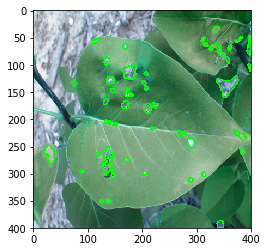

In [5]:
print("spot detected")
plt.imshow(data)

In [15]:
if __name__ == "__main__":
    sd = SpotDetection("infected/img7.png",400)
    data = sd.getSpot()

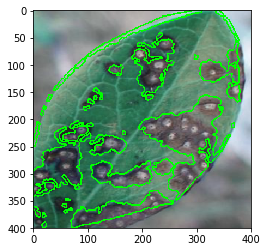

In [16]:
plt.imshow(data)